In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys, gc, keras, time
from IPython.display import display

folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

T = 300
X_fold_lc = np.load("data/LC_global_%dT.npy"%T)
#X_fold_lc_aug = np.load("data/LC_globalA_%dT.npy"%T)
X_fold_time = np.load("data/Time_global_%dT.npy"%T)

#mask_transit = np.load("data/mask_transit_LC.npy")  #

print("X all shape: ",X_fold_lc.shape)

Using TensorFlow backend.


('X all shape: ', (8054, 300))


In [2]:
latent_dim = 16

In [3]:
## pre-processing

#X_all_proc = X_fold_lc/np.abs(X_fold_lc.min(axis=-1, keepdims=True)) # original papers
X_all_proc = X_fold_lc/X_fold_lc.std(axis=-1, keepdims=True) #our setting
#X_to_fit = X_all_proc[mask_transit]

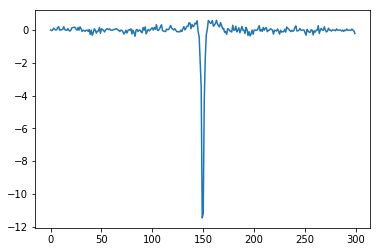

In [59]:
plt.plot(X_all_proc[5])

### SOM
> Armstrong et al. *Transit shapes and self-organizing maps as a tool for ranking planetary candidates: application to Kepler and K2*

https://github.com/DJArmstrong/TransitSOM

sino
https://github.com/JustGlowing/minisom

In [ ]:
import sys
sys.path.insert(1, './otherBasel')
from som_rep import CreateSOM
shape = int(np.sqrt(latent_dim))

In [46]:
out = CreateSOM(X_fold_lc[:100], niter=500,learningrate=0.1,
                #somshape=(20,20))
                somshape=(shape,shape)) #armstrong use 20x20

In [47]:
def transform(data, kernel):
    return np.tensordot(data, kernel, axes=[[1], [-1]])

X_new = transform(X_all_proc, out._K)
X_new.shape

(8054, 20, 20)

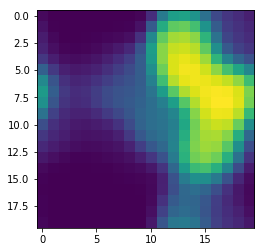

In [53]:
plt.imshow(X_new[60])

In [28]:
out(X_fold_lc)

array([[3, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [41]:
N,k ,k = X_new.shape
X_new = X_new.reshape(N,k*k)
np.save("./LC_features/SOM_%dT_%dD.npy"%(T,latent_dim), X_new)
X_new.shape

array([[ 4.38957060e-02,  9.09269862e-02,  4.61914681e-01, ...,
         4.16978262e-01,  1.87232452e+00,  5.30928554e-01],
       [ 2.52581310e-02,  5.67014985e-02,  2.99942090e-01, ...,
         2.53008158e-01,  1.17087298e+00,  3.21108284e-01],
       [ 3.21845894e-04, -9.50191127e-04, -6.63205083e-03, ...,
        -4.08797936e-03, -1.99536580e-02, -4.56781132e-04],
       ...,
       [ 3.26467214e-02,  9.86955319e-02,  5.51420446e-01, ...,
         4.60033241e-01,  2.16753221e+00,  5.18523948e-01],
       [ 3.56270419e-03,  1.17041108e-02,  6.61873723e-02, ...,
         5.40429602e-02,  2.56126381e-01,  5.91268010e-02],
       [ 3.26834151e-02,  1.08823348e-01,  6.16614516e-01, ...,
         5.19129316e-01,  2.45642057e+00,  5.66109485e-01]])

## LLP
> Thompson et al. *A MACHINE LEARNING TECHNIQUE TO IDENTIFY TRANSIT SHAPED SIGNALS*

https://github.com/jakevdp/lpproj

otra opcion https://github.com/ixjlyons/sklearn-lpp/blob/master/lpp.ipynb

https://sourceforge.net/p/lpptransitlikemetric/discussion/

In [14]:
from lpproj import LocalityPreservingProjection 
lpp = LocalityPreservingProjection(n_components=latent_dim) #LLP use 20
lpp.fit(X_all_proc)

X_new = lpp.transform(X_all_proc)

np.save("./LC_features/LLP_%dT_%dD.npy"%(T,latent_dim), X_new)
X_new.shape

(8054, 16)

## Afiiny Propagation based
https://github.com/cmackenziek/tsfl

K-dimensional vector of similarity to each cluster

affininy propagation pesando los tiempos enla distancia

In [5]:
twed_lambda = 0.5
twed_nu=1e-5

In [ ]:
0.00001

In [8]:
lcs = X_to_fit #np.random.rand(100, 5)
times = X_fold_time[mask_transit] #np.random.rand(100, 5)
part = 1
num_parts = 1

In [9]:
from otherBasel.twed_rep import pairwise_matrix_tweds

D = pairwise_matrix_tweds(lcs, times, part, num_parts,
                   lam=twed_lambda, nu=twed_nu)

N: 4317
num_tweds: 9320403.0
tweds_per_part: 9320403.0
begin_index: 0
end_index: 9320403
part: 1
num_parts: 1


KeyboardInterrupt: 

In [ ]:
plt.imshow(D)

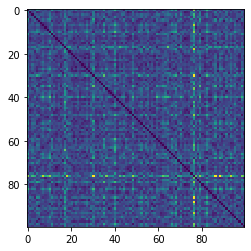

In [16]:
plt.imshow(D)

In [ ]:
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation(affinity='precomputed', verbose=True, damping=0.5, max_iter=200, convergence_iter=15)
ap.fit(D)

In [ ]:
centroid_lcs = [lcs[x] for x in ap.cluster_centers_indices_]
centroid_times = [times[x] for x in ap.cluster_centers_indices_]
print("number of clusters =",len(centroid_lcs))

In [ ]:
from otherBasel.twed_rep import encode_lightcurve_twed

lc_df = encode_lightcurve_twed(centroid_lcs, centroid_times, lcs, times, 
                               twed_lambda, twed_nu, alpha=1, split=True)
lc_df

In [ ]:
patch_mags = datos en lista 
patches_times = tiempo en lista

#cluster_lcs = centroids de affinity
#cluster_times = centroids tiempo de affinity

In [46]:
centroid_lcs = np.random.rand(5,10)
centroid_times =  np.random.rand(5,10)
patch_mags = np.random.rand(100,10)
patch_times = np.random.rand(100,10)